# Utils

In [1]:
import warnings
import umap
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import hdbscan
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter(action='ignore', category=FutureWarning)

from analysis import umap_run, clustering_evaluation, clustering
from preprocessing import processflat

importlib.reload(umap_run)
importlib.reload(clustering_evaluation)
importlib.reload(unsupervised_clustering)
importlib.reload(processflat)

from preprocessing.processflat import x_features_return
from analysis.clustering import plot_clusters_vs_groups
from analysis.umap_run import run_umap

%load_ext autoreload
%autoreload 2

In [2]:
# FC maps directories
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/data/FCmaps_augmented_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"

# Path to masks
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'

# Metadata
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'
path_df_meta = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/meta/df_meta.csv"

# Done dataframe of preprocessed FC maps
path_df_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_gm.pkl"
path_df_thr02_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_thr02_gm.pkl"

# Umap

## Input Data

For the further analysis we will remove the ID labels columns, but the order is maintained.

Possible dataset from mean maps:
- `df_thr01_gm_masked`
- `df_thr02_gm_masked`
- `df_thr01_har_masked`
- `df_thr02_har_masked`
- `df_gm_masked`
- `df_har_masked`

Possible dataset from mean network:
- `df_networks_no_thr`
- `df_networks_thr01`
- `df_networks_thr02`

Here we go with one example

In [36]:
# Load dataframes
df_gm = pd.read_pickle(path_df_gm)
df_meta = pd.read_csv(path_df_meta)

# Merge with metadata
df_merged, X = x_features_return(df_gm, df_meta)


-------------------- Dataset Info --------------------
Meta columns (Labels and Covariates):        8
Feature matrix shape (X):                (176, 161817)
Complete dataframe shape after merge:    (176, 161825)
-------------------------------------------------------



## Dimensionality Reduction

UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced dataset.

In [37]:
np.random.seed(42)

In [38]:
# Parameters
umap_params = {'n_neighbors': 15, 'n_components': 2, 'metric': 'euclidean', 'n_epochs': 1000, 'learning_rate': 1.0, 'init': 'spectral', 'min_dist': 0.1, 'spread': 1.0, 'low_memory': False, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'a': None, 'b': None, 'random_state': 42, 'metric_kwds': None, 'angular_rp_forest': False, 'target_n_neighbors': -1, 'transform_seed': 42, 'verbose': False, 'unique': False}
reducer = umap.UMAP(**umap_params)

# Fit the model
X_umap = reducer.fit_transform(X)

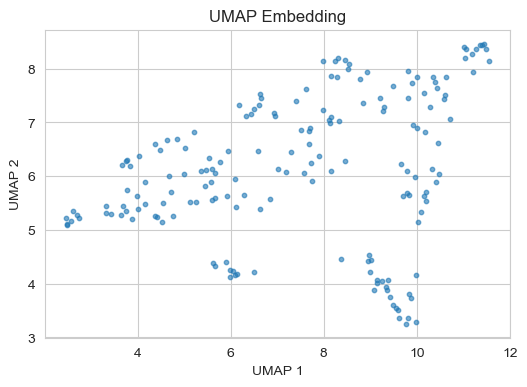

In [39]:
plt.figure(figsize=(6, 4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
plt.title("UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

# Unsupervised Clustering

## Fit models

In [40]:
# HDBSCAN
cluster_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = cluster_hdb.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=7, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

Result collection

In [41]:
labels_dict = {
    "HDBSCAN": labels_hdb,
    "K-Means": labels_km,
}

labels_df = pd.DataFrame({
    'ID': df_merged['ID'],
    'Group': df_merged['Group'],
    'CDR_SB': df_merged['CDR_SB'],
    'MMSE': df_merged['MMSE'],
    'labels_gmm_cdr': df_merged['labels_gmm_cdr'],
    'HDBSCAN': labels_hdb,
    'KMeans': labels_km,
})

#labels_df.to_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/utils/clustering_labels_by_ID.csv", index=False)

## Optimal number of clusters

In [42]:
# K-Means optimal clusters
#inertias, sil_scores = evaluate_kmeans(X_umap,K_range=range(2, 11),save_path=None,prefix= "gm",plot_flag=True)

# Consensus clustering
#stability_scores = evaluate_consensus(X_umap,K_range=range(2, 11),n_runs=100,save_path=None,prefix='gm',plot_flag=True)

# HDBSCAN optimal clusters
#labels_hdb, n_hdb = evaluate_hdbscan(X_umap, min_cluster_size=5)

## Plotting

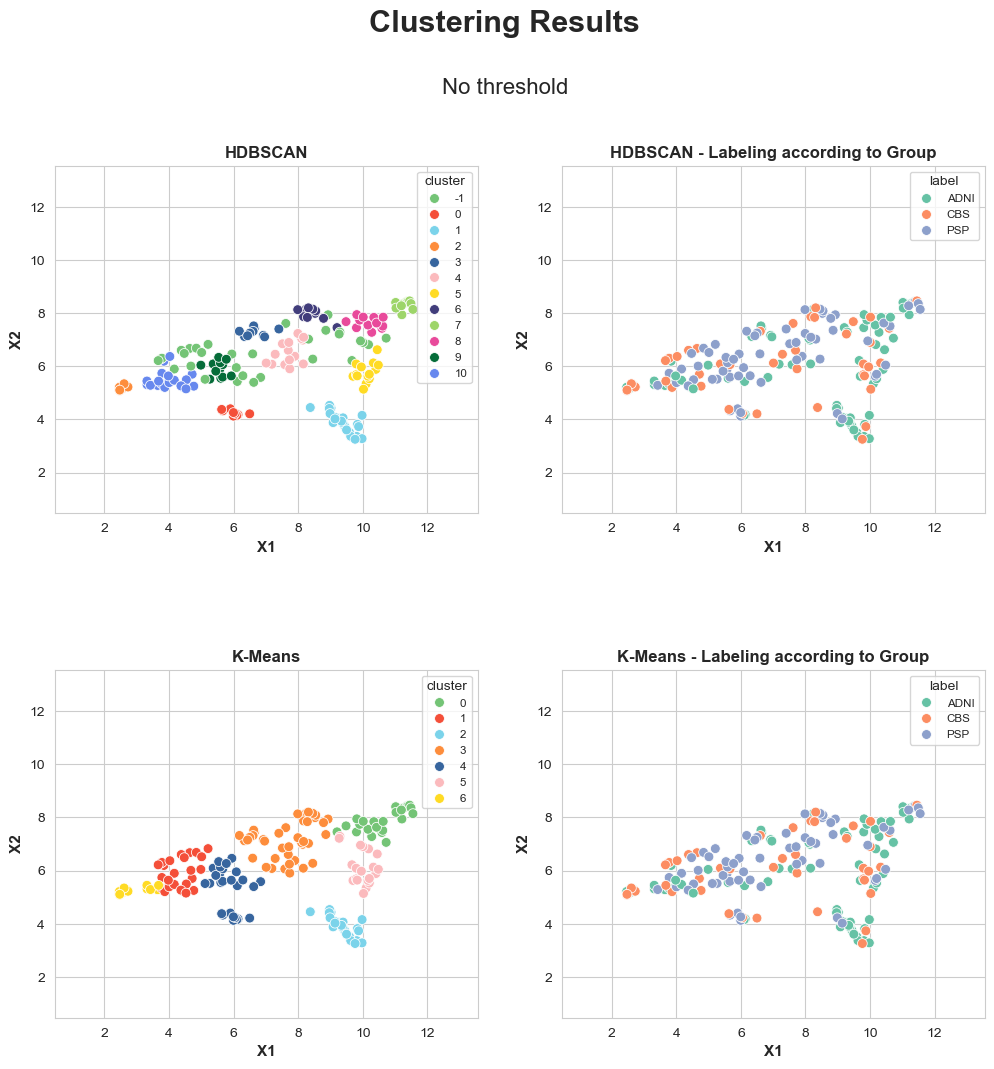

In [43]:
plot_clusters_vs_groups(X_umap, labels_dict, labels_df['Group'], save_path = None, title_prefix ='No threshold', margin = 2.0, plot_flag=True)

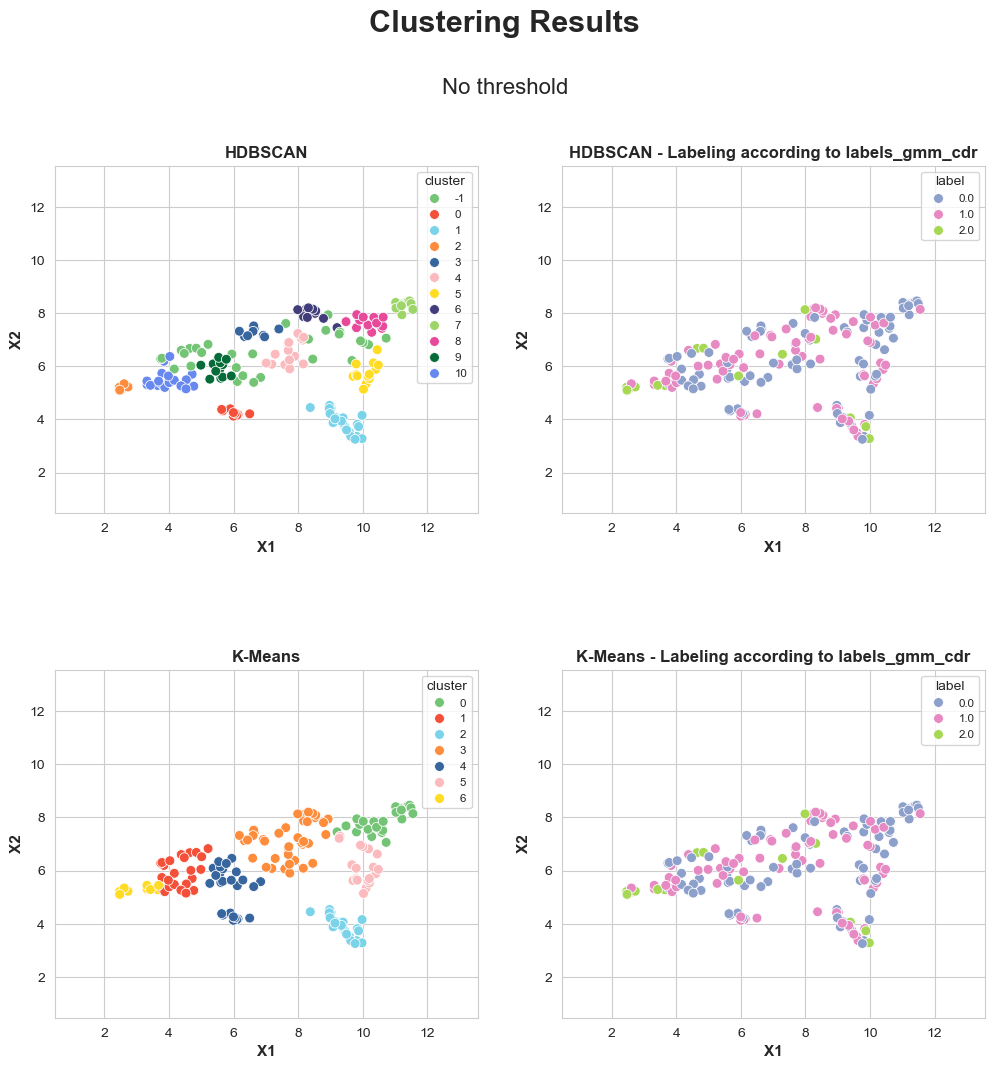

In [44]:
plot_clusters_vs_groups(X_umap, labels_dict, labels_df['labels_gmm_cdr'], save_path = None, title_prefix ='No threshold', margin= 2.0, plot_flag=True, colors_gmm= True)

## Statistical Evaluation

In [12]:
diagnoses = ['ADNI', 'CBS', 'PSP']

for diag in diagnoses:
    print(f"\n=== Chi-squared test for {diag} ===")

    # Crea colonna binaria con etichette leggibili
    labels_df[f'{diag}_label'] = labels_df['Group'].apply(lambda x: diag if x == diag else 'other')

    # Tabella di contingenza: Cluster vs (diag vs other)
    contingency = pd.crosstab(labels_df['KMeans'], labels_df[f'{diag}_label'])
    print("Contingency Table:")
    print(contingency)

    # Chi-squared test
    chi2, p_value, dof, expected = chi2_contingency(contingency)

    # Output
    print(f"\nChi² = {chi2:.4f}")
    print(f"p-value = {p_value:.4f}")
    print(f"Degrees of Freedom = {dof}")


=== Chi-squared test for ADNI ===
Contingency Table:
ADNI_label  ADNI  other
KMeans                 
0             25     41
1             25     53
2             22     10

Chi² = 13.0431
p-value = 0.0015
Degrees of Freedom = 2

=== Chi-squared test for CBS ===
Contingency Table:
CBS_label  CBS  other
KMeans               
0           17     49
1           21     57
2            6     26

Chi² = 0.8407
p-value = 0.6568
Degrees of Freedom = 2

=== Chi-squared test for PSP ===
Contingency Table:
PSP_label  PSP  other
KMeans               
0           24     42
1           32     46
2            4     28

Chi² = 8.4602
p-value = 0.0146
Degrees of Freedom = 2


# Supervised Clustering

- csv split from cnn
- 5-fold cross-validation
- cambia seed e vai a vedere meand and standard deviation

In [29]:
# Load dataframes
df_gm = pd.read_pickle(path_df_gm)
df_meta = pd.read_csv(path_df_meta)

# Merge with metadata
df_merged, X = x_features_return(df_gm, df_meta)

# Select specific pair of groups
pair = ("ADNI", "PSP")
df_pair = df_merged[df_merged['Group'].isin(pair)].copy()
X_pair = X.loc[df_pair.index].values  # ensure correct alignment
y_pair = df_pair["Group"].values


-------------------- Dataset Info --------------------
Meta columns (Labels and Covariates):        8
Feature matrix shape (X):                (176, 161817)
Complete dataframe shape after merge:    (176, 161825)
-------------------------------------------------------



In [30]:
# Run UMAP on the selected pair of groups
X_umap = run_umap(X_pair, plot_flag=False, title=f"{pair[0]} vs {pair[1]}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_pair)

# Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_umap, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train a classifier
clf = SVC(kernel='rbf', probability=True, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Running UMAP...



In [31]:
# Aggregate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
try:
    auc_roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
except Exception as e:
    auc_roc = None
    print("AUC-ROC not computed:", e)

print("Aggregate Metrics:")
print(f"Accuracy  : {accuracy:.2f}")
print(f"Precision : {precision:.2f}")
print(f"Recall    : {recall:.2f}")
print(f"F1-score  : {f1:.2f}")
if auc_roc is not None:
    print(f"AUC-ROC   : {auc_roc:.2f}")
print("\n")

# Class metrics
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)
per_class_metrics = report_df.loc[le.classes_]
class_df = report_df.loc[le.classes_]
display(class_df)
print("\n")

Aggregate Metrics:
Accuracy  : 0.48
Precision : 0.46
Recall    : 0.47
F1-score  : 0.46
AUC-ROC   : 0.67




,precision,recall,f1-score,support
ADNI,0.53,0.60,0.56,15.0
PSP,0.40,0.33,0.36,12.0


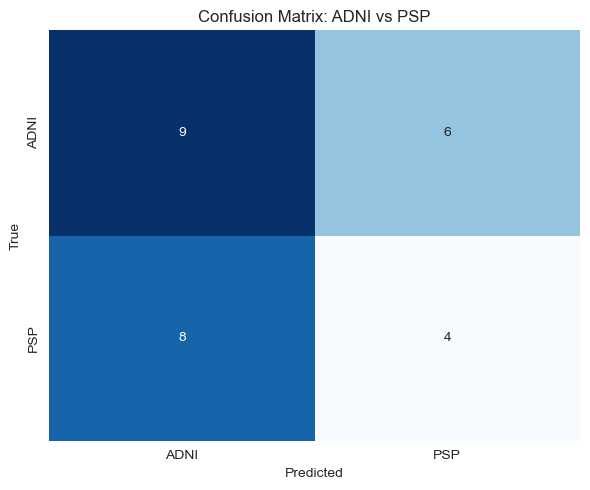

In [33]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix: {pair[0]} vs {pair[1]}")
plt.tight_layout()
plt.show()